In [57]:
#####################################################################################################################
#                                                                                                                   #
# Libraries                                                                                                         #
#                                                                                                                   #
#####################################################################################################################
from matplotlib import pyplot as plt

plt.rcParams['figure.dpi'] = 200 # Plot resolution (dpi)
import pandas as pd
import numpy as np
import os
from scipy import stats
from itertools import combinations
import seaborn as sns
from scipy.stats import friedmanchisquare, wilcoxon
import itertools
from IPython.display import display
from scipy.stats import shapiro



In [79]:
file_path = '/Users/bodamjerry/Downloads/GermanyMacroData/'
os.chdir(file_path)

read_dir = "cpi_1_step_rolling_model_results/"
os.makedirs(read_dir, exist_ok=True)
print(f"Current working directory: {os.getcwd()}")



Current working directory: /Users/bodamjerry/Downloads/GermanyMacroData


In [80]:
forecast_df = pd.read_csv(read_dir + 'all_forecasts.csv', index_col=0)
mae_df = pd.read_csv(read_dir + 'all_mae.csv', index_col=0)
rmse_df = pd.read_csv(read_dir + 'all_rmse.csv', index_col=0)

In [81]:
print(len(forecast_df))

100


In [82]:
def plot_metric_with_std(metric_df, title):
    plt.figure(figsize=(10, 6))
    for col in metric_df.columns:
        mean_vals = metric_df[col].mean()
        std_vals = metric_df[col].std()
        plt.errorbar([col], [mean_vals], yerr=[std_vals], fmt='o', capsize=5, label=col)

    plt.title(f"{title} Across 100 Sliding Samples (Mean ± Std Dev)")
    plt.ylabel(title)
    plt.xticks(rotation=45)
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    # plt.grid(False)
    plt.tight_layout()
    plt.show()


def boxplot_metric_distribution(metric_df, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=metric_df, palette="Set3")
    plt.title(f"{title} Distribution Across 100 Rolling Samples")
    plt.ylabel(title)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_mae_mirror_barplot(mae_df, title="Mirror Barplot of MAE and Deviation"):
    """
    Creates a mirror barplot showing average MAE (right) and its deviation (left) for each model.
    Parameters:
    - mae_df: DataFrame where each column is a model and each row is an iteration
    """
    # Drop Iteration column if present
    df = mae_df.drop(columns='Iteration', errors='ignore')
    # Compute mean and std
    mae_means = df.mean().sort_values()
    mae_stds = df.std().reindex(mae_means.index)

    models = mae_means.index
    y_pos = np.arange(len(models))

    # Plot
    fig, ax = plt.subplots(figsize=(13, len(models) * 0.5 + 2))

    bar_height = 0.6
    mean_color = 'blue'
    std_color = 'darkorange'

    # Plot bars
    ax.barh(y_pos, mae_means.values, height=bar_height, color=mean_color, alpha=0.4, label='Mean MAE')
    ax.barh(y_pos, -mae_stds.values, height=bar_height, color=std_color, alpha=0.4, label='Std Dev')
    # Text labels
    for i, (model, mean, std) in enumerate(zip(models, mae_means.values, mae_stds.values)):
        # Mean value at the end
        ax.text(mean + 0.002, i, f"{mean:.4f}", va='center', ha='left', fontsize=9, color='black')
        # Std value on left
        ax.text(-std - 0.002, i, f"{std:.4f}", va='center', ha='right', fontsize=9, color='dimgray')

        # Model name inside the bar (centered between mean and std ends)
        center_pos = 0 if mean < 0.2 else mean / 2  # handle small mean case
        ax.text(0, i, model.upper(), va='center', ha='center', fontsize=9, color='black', fontweight='bold')

    # Format
    ax.set_yticks(y_pos)
    ax.set_yticklabels([''] * len(models))  # Hide y-axis labels (since we write them in bars)
    # ax.axvline(0, color='black', linewidth=1.2)
    ax.set_xlabel("MAE (Right: Mean | Left: Std Dev)", fontsize=12)
    ax.set_title(title, fontsize=15, weight='bold', pad=15)
    ax.legend(loc='lower right')
    # ax.grid(True, axis='x', linestyle='--', alpha=0.4)
    ax.grid(False)
    plt.tight_layout()
    plt.show()



def plot_mae_with_highlight_and_bands(mae_df, highlight_models=None, mark_best_model=None, errorbar=('ci', 95),
                                      title="MAE Across 100 Sliding Samples (With 95% CI)"):
    df = mae_df.reset_index(drop=True).copy()
    df.index.name = "Iteration"
    df = df.reset_index()
    mae_melted = df.melt(id_vars="Iteration", var_name="Model", value_name="MAE")

    highlight_models = [m.upper() for m in highlight_models] if highlight_models else []
    mark_best_model = mark_best_model.upper() if mark_best_model else None

    # Find best periods for mark_best_model
    best_iterations = []
    if mark_best_model:
        for i, row in mae_df.iterrows():
            if row.idxmin().upper() == mark_best_model:
                best_iterations.append(i)

    # Prepare plot
    fig, ax = plt.subplots(figsize=(14, 7))

    # Gray background lines for all models
    for model in mae_melted['Model'].unique():
        model_upper = model.upper()
        if model_upper not in highlight_models and model_upper != mark_best_model:
            data = mae_melted[mae_melted['Model'].str.upper() == model_upper]
            sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
                         color='lightgray', linewidth=1, alpha=0.5, label=None, errorbar=None)

    # Highlighted lines
    palette = sns.color_palette("tab10", len(highlight_models))
    for i, model in enumerate(highlight_models):
        data = mae_melted[mae_melted['Model'].str.upper() == model]
        sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
                     linewidth=2.2, label=model, color=palette[i], errorbar=errorbar)

    # Highlight best-performing spans
    if mark_best_model and best_iterations:
        for iteration in best_iterations:
            ax.axvspan(iteration - 0.5, iteration + 0.5, color='lightblue', alpha=0.3, lw=0)

        # Optional: label this in legend
        ax.plot([], [], color='lightblue', alpha=0.4, linewidth=10, label=f"{mark_best_model} best period")

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Iteration", fontsize=14)
    ax.set_ylabel("MAE", fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(title="Model", fontsize=10)
    plt.tight_layout()
    plt.show()
    return best_iterations



def plot_mae_with_highlight_bands_btw(mae_df, highlight_models=None, mark_best_model=None, errorbar=('ci', 95),
                                      title="MAE Across 100 Sliding Samples (With 95% CI)"):
    """
    Plot MAE trajectories for multiple models with confidence intervals.
    Highlights specific models and marks iterations where a designated model
    performs best *among the highlighted models*.

    Parameters:
    - mae_df (pd.DataFrame): DataFrame where columns are model names and rows are iterations (0 to 99).
    - highlight_models (list, optional): List of model names (strings) to highlight with distinct colors.
                                         e.g., ['VAR', 'ARIMA']
    - mark_best_model (str, optional): A single model name (string). Iterations where this model
                                       is the best *among the highlight_models* will be marked.
    - ci (int or 'sd', optional): Confidence interval size for Seaborn lineplot. Default is 95.
                                  Use 'sd' for standard deviation band.
    - title (str): Title of the plot.
    """

    df = mae_df.reset_index(drop=True).copy()
    df.index.name = "Iteration"
    df = df.reset_index()
    mae_melted = df.melt(id_vars="Iteration", var_name="Model", value_name="MAE")

    # Ensure model names are consistently upper-cased for comparison
    mae_melted['Model'] = mae_melted['Model'].str.upper()

    highlight_models_upper = [m.upper() for m in highlight_models] if highlight_models else []
    mark_best_model_upper = mark_best_model.upper() if mark_best_model else None

    best_iterations = []
    if mark_best_model_upper and highlight_models_upper:
        # Filter mae_df to include only models that are in highlight_models
        # This creates a DataFrame subset with only the MAE values of interest
        relevant_mae_data = mae_df[[col for col in mae_df.columns if col.upper() in highlight_models_upper]]

        for i, row in relevant_mae_data.iterrows():
            # Find the model with the minimum MAE in the current iteration
            # among the SUBSET of highlighted models
            best_model_in_subset = row.idxmin().upper() # idxmin() returns the column name of the min value

            # If this best model in the subset is our designated mark_best_model
            if best_model_in_subset == mark_best_model_upper:
                best_iterations.append(i)

    # Prepare plot
    fig, ax = plt.subplots(figsize=(14, 7))

    # Determine unique models in the melted DataFrame (now upper-cased)
    all_unique_models_in_df = mae_melted['Model'].unique()

    # Gray background lines for all models NOT specifically highlighted or marked as best
    for model_name_upper in all_unique_models_in_df:
        if model_name_upper not in highlight_models_upper and model_name_upper != mark_best_model_upper:
            data = mae_melted[mae_melted['Model'] == model_name_upper]
            sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
                         color='lightgray', linewidth=1, alpha=0.5, label=None, errorbar=None) # ci=None to remove CI for background

    # Highlighted lines
    # Ensure a consistent color palette if highlight_models is not empty
    if highlight_models_upper:
        palette = sns.color_palette("tab10", len(highlight_models_upper))
        for i, model_to_highlight_upper in enumerate(highlight_models_upper):
            data = mae_melted[mae_melted['Model'] == model_to_highlight_upper]
            sns.lineplot(data=data, x="Iteration", y="MAE", ax=ax,
                         linewidth=2.2, label=model_to_highlight_upper, color=palette[i], errorbar=errorbar)

    # Highlight best-performing spans for the designated mark_best_model
    if mark_best_model_upper and best_iterations:
        for iteration in best_iterations:
            ax.axvspan(iteration - 0.5, iteration + 0.5, color='lightblue', alpha=0.3, lw=0)

        # Add a legend entry for the marked periods
        ax.plot([], [], color='lightblue', alpha=0.4, linewidth=10,
                label=f"{mark_best_model_upper} best (among highlighted)")

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Iteration", fontsize=14)
    ax.set_ylabel("MAE", fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(title="Model", fontsize=10)
    plt.tight_layout()
    plt.show()
    return best_iterations



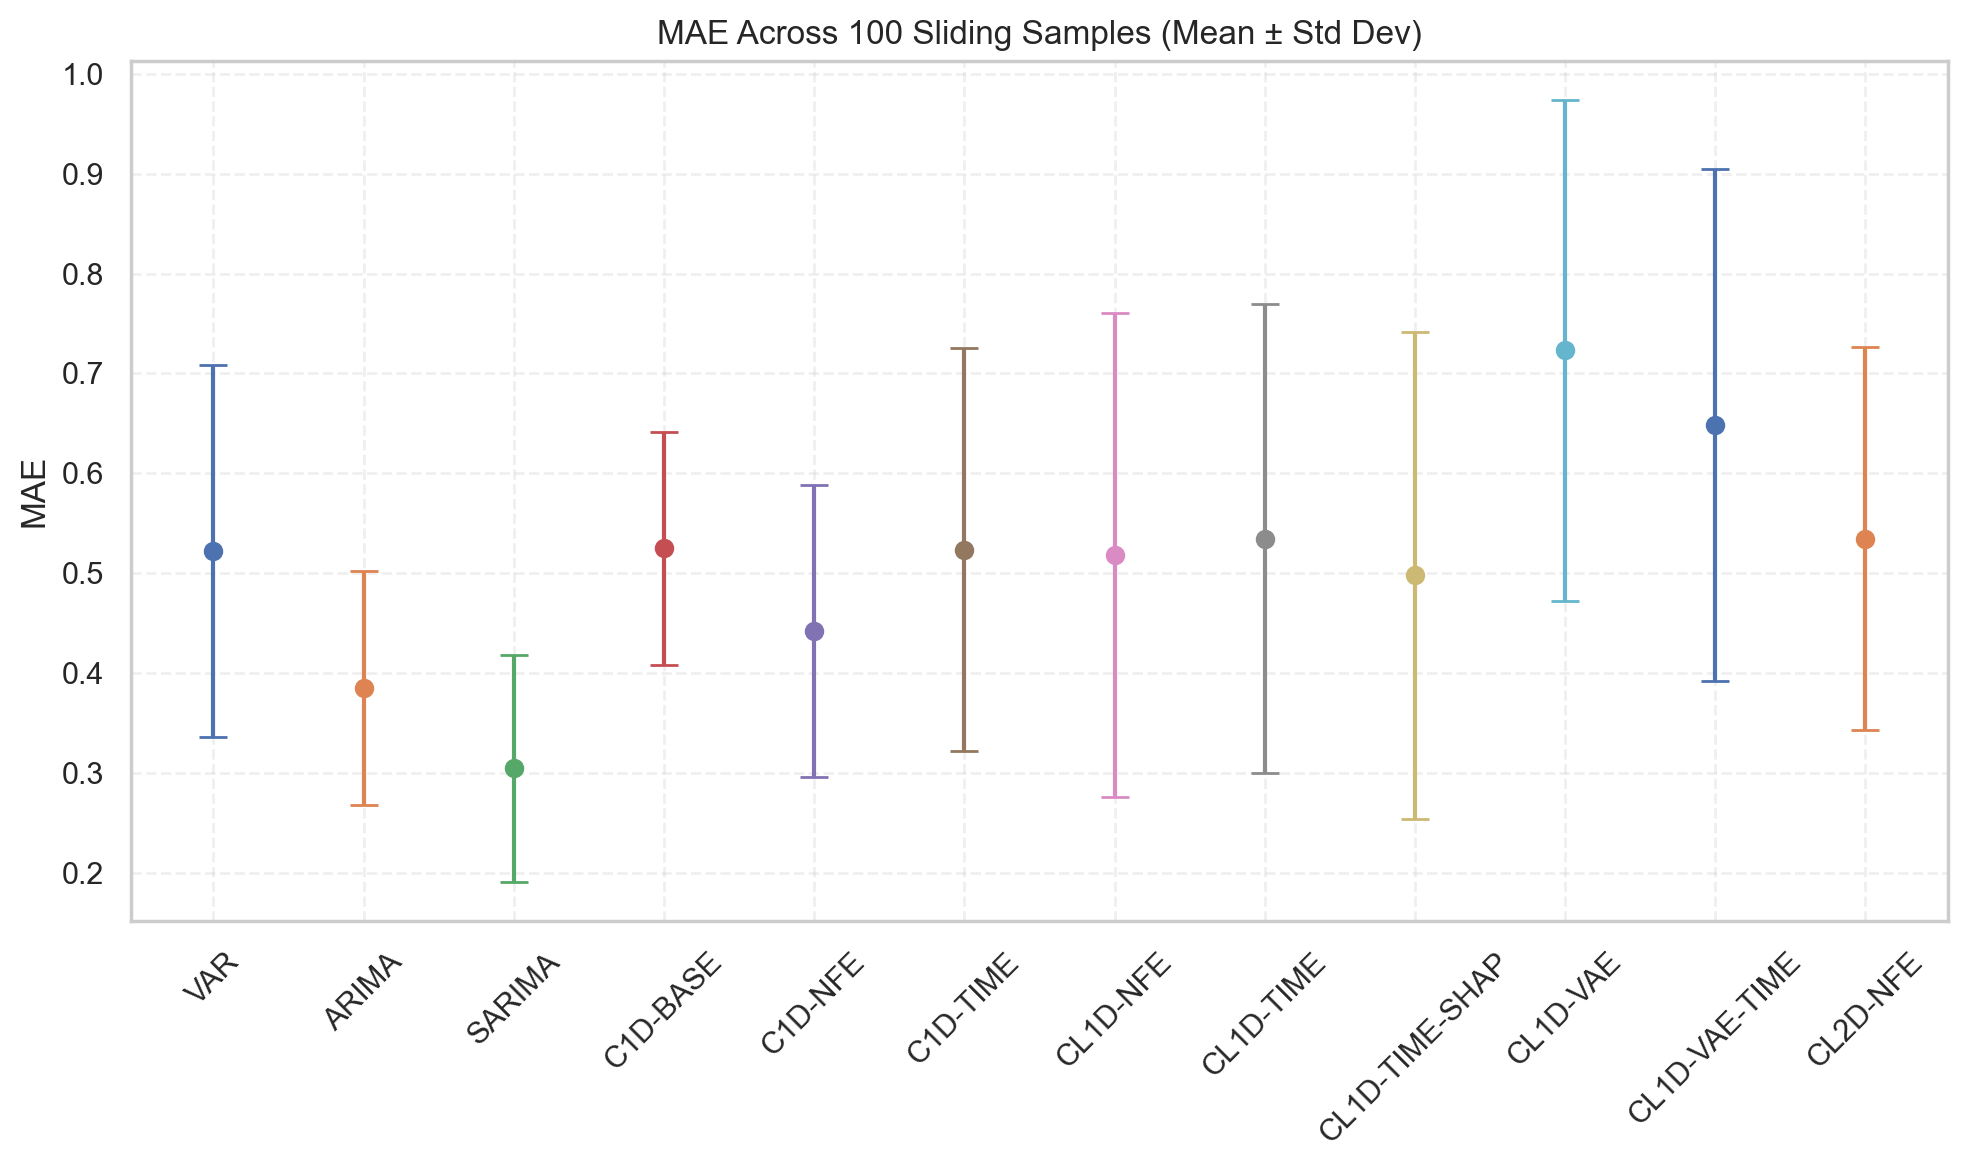

In [83]:
plot_metric_with_std(mae_df, "MAE")

In [84]:
# Melt the data for Seaborn
# Reset index to make 'Iteration' a column again
mae_df_r = mae_df.copy().reset_index()
rmse_df_r = rmse_df.copy().reset_index()
mae_melted = mae_df_r.melt(id_vars="Iteration", var_name="Model", value_name="MAE")
rmse_melted = rmse_df_r.melt(id_vars="Iteration", var_name="Model", value_name="RMSE")

# Compute mean MAE and RMSE per model
mean_mae = mae_df_r.drop(columns="Iteration", errors='ignore').mean()
mean_rmse = rmse_df_r.drop(columns="Iteration", errors='ignore').mean()


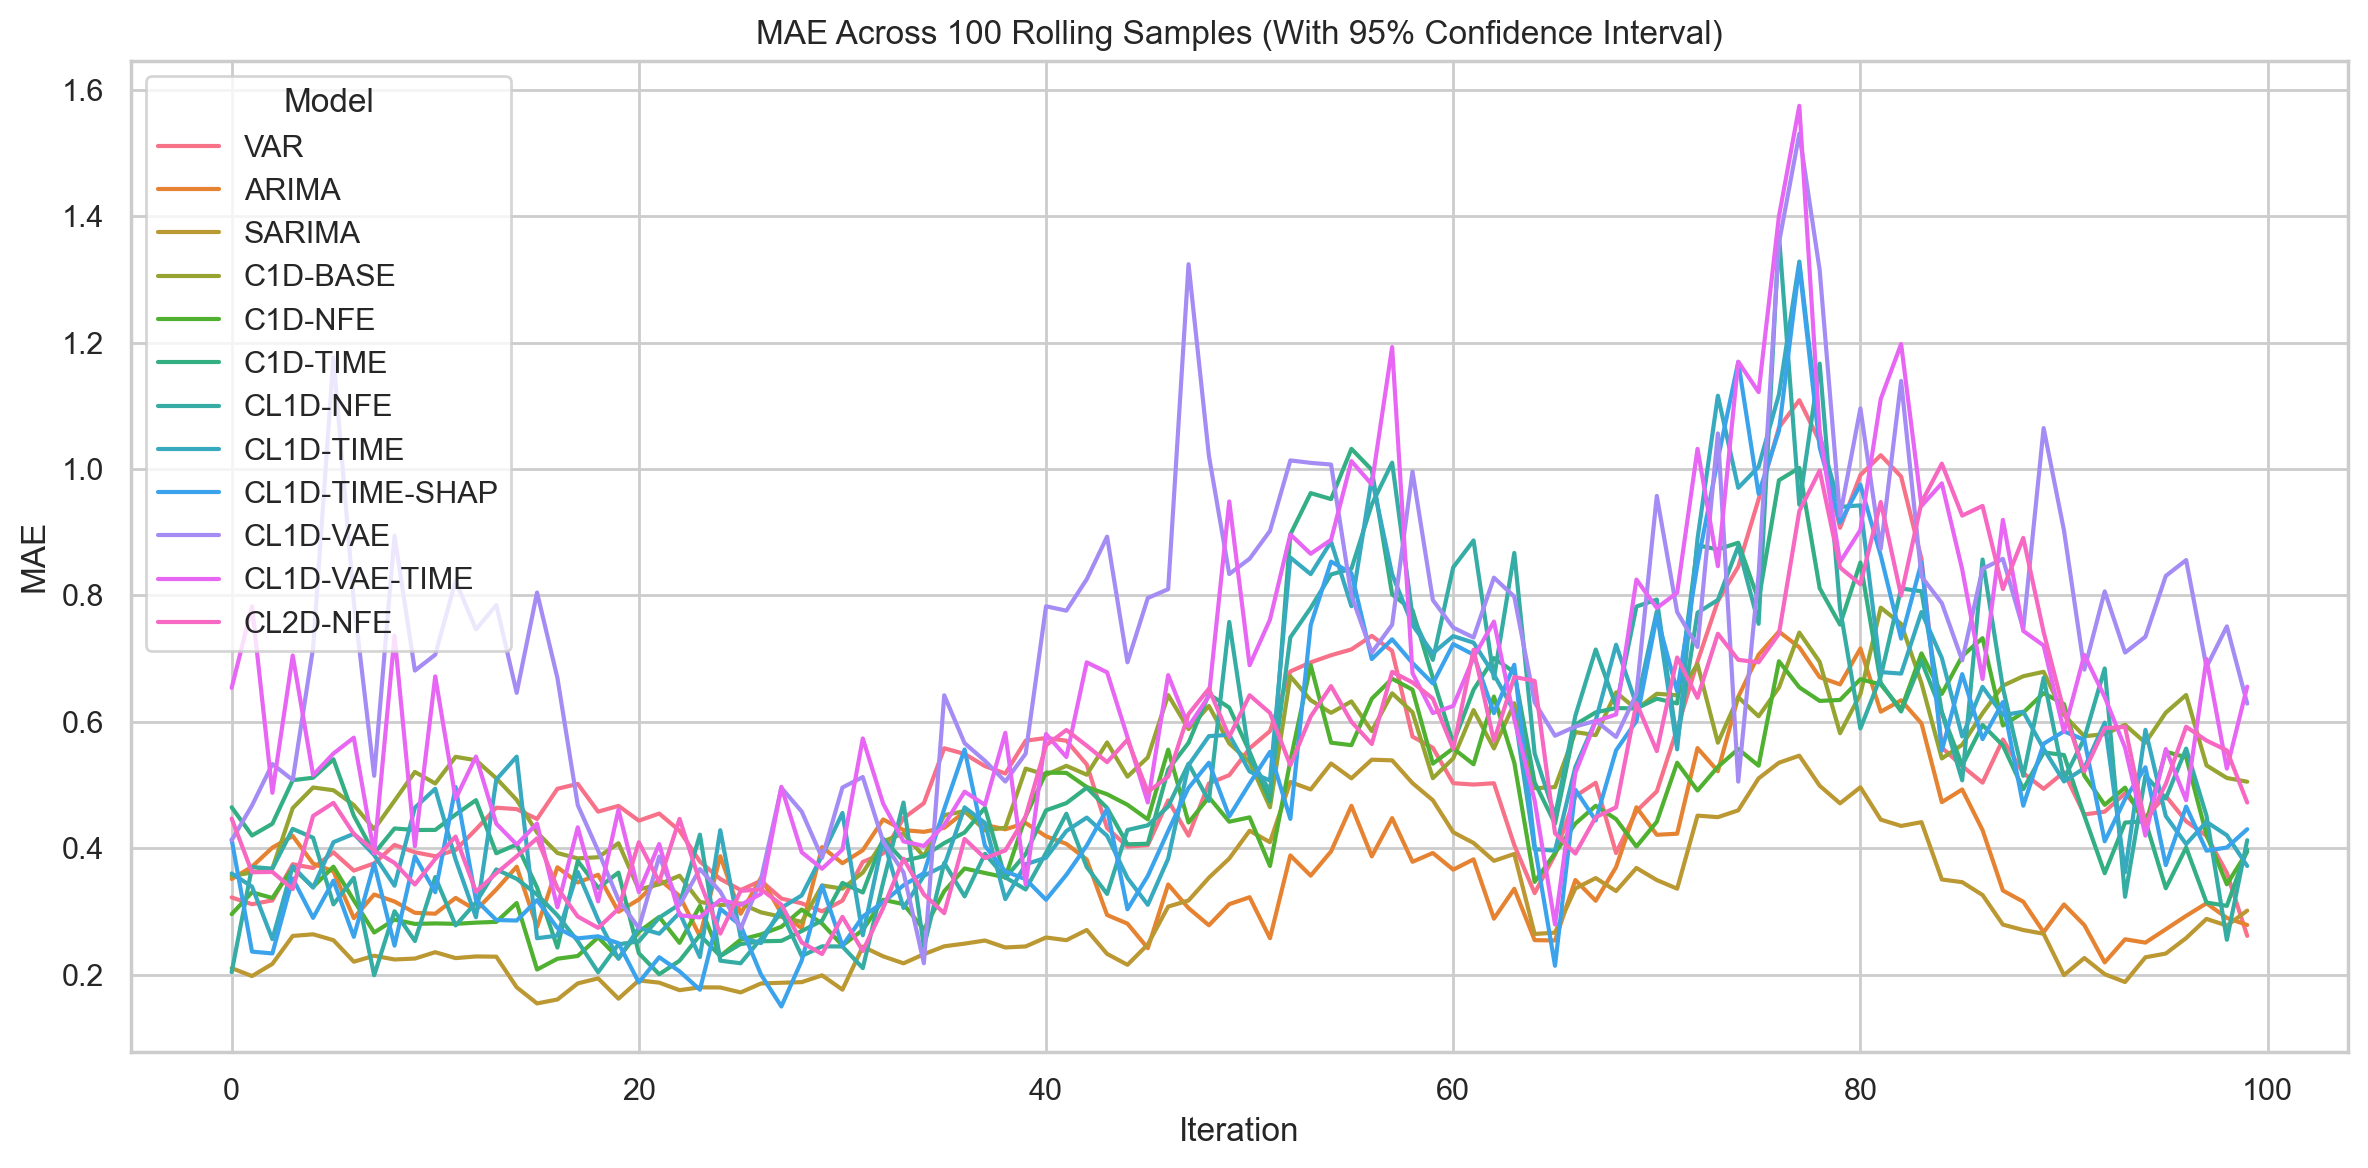

In [85]:

# Plot MAE
plt.figure(figsize=(12, 6))
sns.lineplot(data=mae_melted, x="Iteration", y="MAE", hue="Model", errorbar=('ci', 95))
plt.title("MAE Across 100 Rolling Samples (With 95% Confidence Interval)")
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.grid(True)
plt.tight_layout()
plt.show()



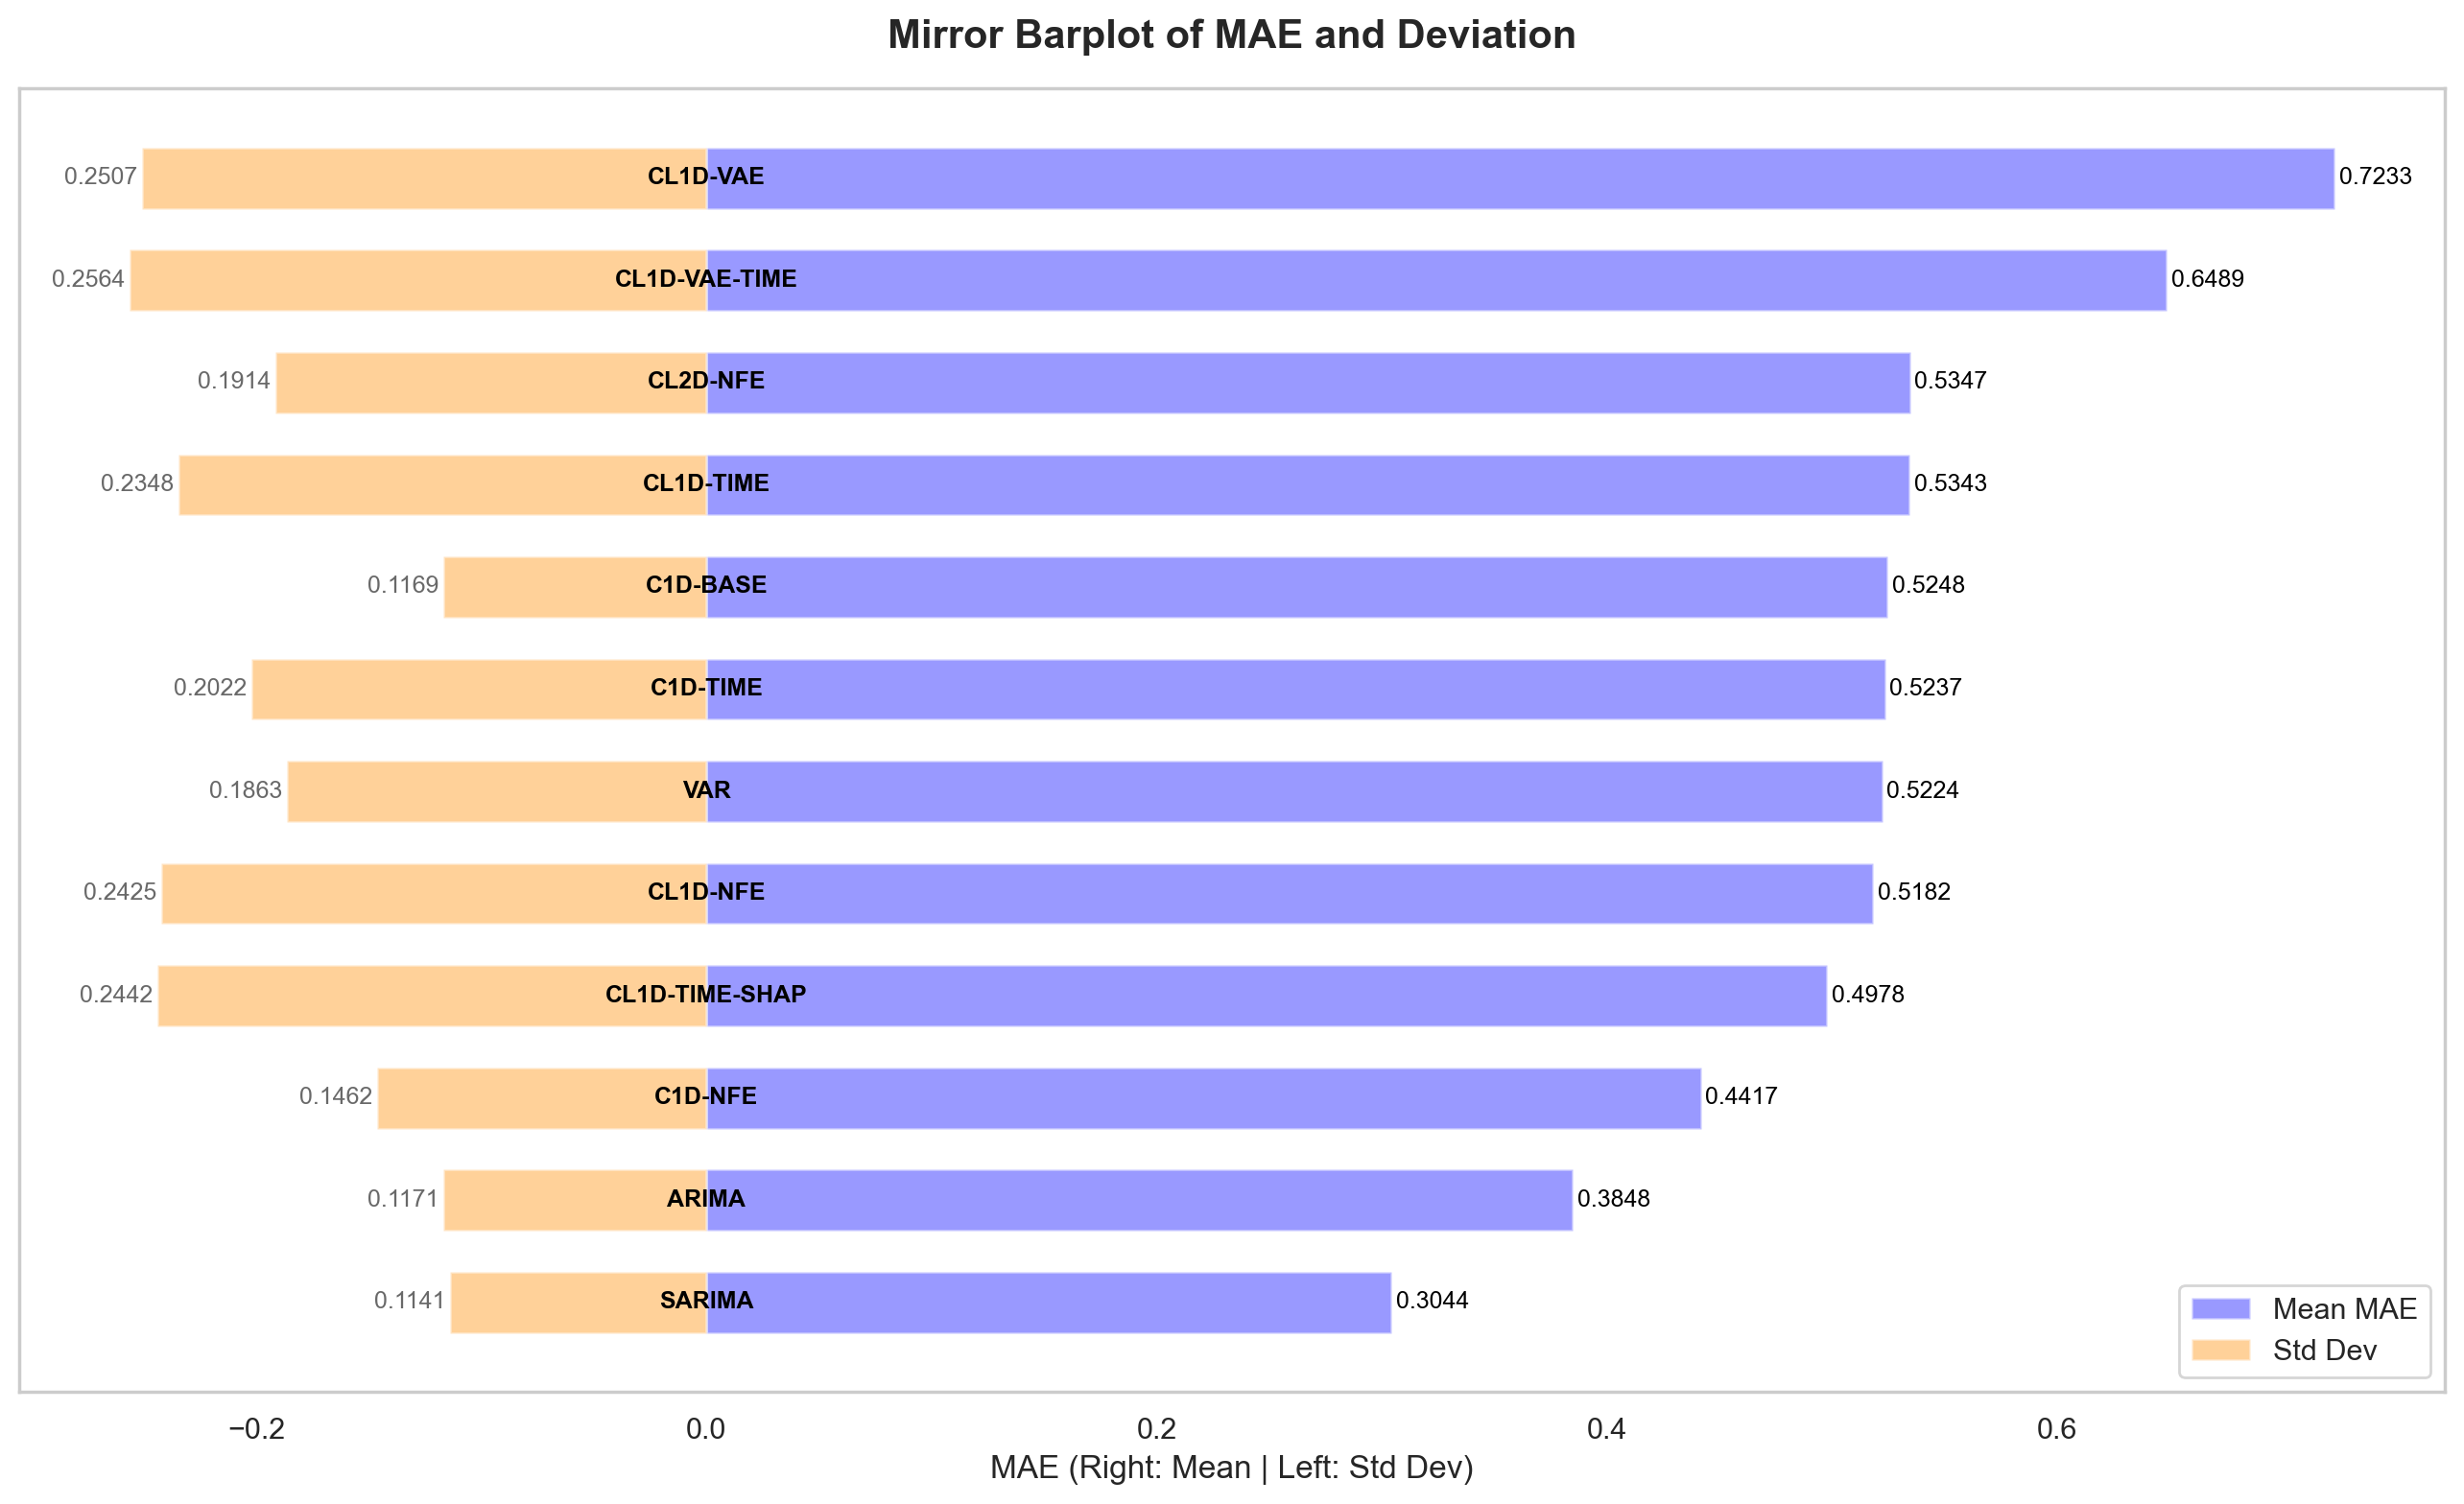

In [86]:
plot_mae_mirror_barplot(mae_df)


In [66]:


def plot_model_performance_panels(mae_df, models_to_plot=None, errorbar=('ci', 95), title="MAE Across 100 Iterations (Per Model Highlighted)"):
    """
    Multi-panel line plot of model MAEs over iterations, highlighting one model per panel.

    Parameters:
    - mae_df: DataFrame with shape (iterations, models)
    - models_to_plot: List of model names to include (optional)
    - ci: Confidence interval shading for highlighted model (default: 95)
    - title: Title of the figure
    """
    # Reshape to long format
    melted_df = mae_df.reset_index(drop=True).reset_index().melt(id_vars="index", var_name="Model", value_name="MAE")
    melted_df = melted_df.rename(columns={"index": "Iteration"})

    all_models = melted_df['Model'].unique()
    models = [m for m in models_to_plot if m in all_models] if models_to_plot else all_models
    n_models = len(models)
    n_cols = 3
    n_rows = int(np.ceil(n_models / n_cols))

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, model in enumerate(models):
        ax = axes[i]

        # Plot all other models in gray
        for other in models:
            if other != model:
                sns.lineplot(
                    data=melted_df[melted_df['Model'] == other],
                    x="Iteration", y="MAE",
                    color='lightgray', alpha=0.4, linewidth=1,
                    errorbar=None, ax=ax
                )

        # Plot the highlighted model
        sns.lineplot(
            data=melted_df[melted_df['Model'] == model],
            x="Iteration", y="MAE",
            label=model.upper(),
            ax=ax, linewidth=2, errorbar=ci
        )

        ax.set_title(model.upper(), fontsize=10, weight='bold')
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend().remove()

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, fontsize=16, weight='bold')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_model_performance_panels_bands(mae_df, models_to_plot=None, errorbar=('ci', 95), title="MAE Across 100 Iterations (Per Model Highlighted)"):

    # Ensure iteration index is numeric and 0-based for consistent plotting
    mae_df_processed = mae_df.copy().reset_index(drop=True)
    best_models_per_iteration = mae_df_processed.idxmin(axis=1)

    # Create a mapping from model name to a list of iterations where it was best
    best_iterations_map = {model_name: [] for model_name in mae_df_processed.columns}
    for iter_idx, best_model_name in best_models_per_iteration.items():
        best_iterations_map[best_model_name].append(iter_idx)

    # Prepare DataFrame for melting (for Seaborn plotting)
    melted_df = mae_df_processed.reset_index().rename(columns={"index": "Iteration"})
    melted_df = melted_df.melt(id_vars="Iteration", var_name="Model", value_name="MAE")

    all_models_in_data = mae_df_processed.columns.tolist() # Get all original model names
    models_to_display = [m for m in models_to_plot if m in all_models_in_data] if models_to_plot else all_models_in_data

    n_models = len(models_to_display)
    if n_models == 0:
        print("No models found to plot. Check 'models_to_plot' and 'mae_df' columns.")
        return

    n_cols = 3 # Number of columns in the subplot grid
    n_rows = int(np.ceil(n_models / n_cols))

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 3.5 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten() # Flatten the axes array for easy iteration

    # --- Plotting loop ---
    for i, model in enumerate(models_to_display):
        ax = axes[i]

        # Plot all other models in gray background
        for other_model in all_models_in_data: # Compare against ALL models in the original mae_df
            if other_model != model:
                sns.lineplot(
                    data=melted_df[melted_df['Model'] == other_model],
                    x="Iteration", y="MAE",
                    color='lightgray', alpha=0.4, linewidth=1,
                    errorbar=None, ax=ax # ci=None to remove confidence interval for background lines
                )

        # Plot the current highlighted model's line
        # Use the label parameter here; legend will be created manually later for the figure
        sns.lineplot(
            data=melted_df[melted_df['Model'] == model],
            x="Iteration", y="MAE",
            label=model, # Keep label for potential manual legend creation later
            ax=ax, linewidth=2, errorbar=errorbar
        )

        # Highlight periods where the current 'model' is the overall best
        best_periods_for_current_model = best_iterations_map.get(model, [])
        if best_periods_for_current_model:
            for iter_idx in best_periods_for_current_model:
                ax.axvspan(iter_idx - 0.5, iter_idx + 0.5, color='lightgreen', alpha=0.3, lw=0) # Use 'lightgreen' for best periods

        ax.set_title(model, fontsize=11, weight='bold') # Set subplot title to model name
        ax.set_xlabel("Iteration", fontsize=9)
        ax.set_ylabel("MAE", fontsize=9)
        ax.tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis labels if needed
        ax.tick_params(axis='y', labelsize=8)
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend().remove() # Remove individual subplot legends to create a single figure legend

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # --- Create a single, unified legend for the entire figure ---
    # This involves getting handles and labels from the plotted lines and the highlight patch
    handles, labels = [], []

    # 1. Add legend entry for the "Best Performance" highlight
    best_performance_patch = plt.Rectangle((0, 0), 1, 1, fc="lightgreen", alpha=0.3, edgecolor='none')
    handles.append(best_performance_patch)
    labels.append("Best Performance (Overall)")

    # 2. Add legend entries for each model's line
    # Iterate through models_to_display to ensure correct order and colors for legend
    # Seaborn automatically assigns colors if not specified. We can retrieve them.
    # This assumes models_to_display are ordered similarly to the internal Seaborn palette.
    for model in models_to_display:
        # Find a line object for the model in the first subplot it was plotted
        line_objects = [line for line in axes[0].get_lines() if line.get_label() == model]
        if line_objects:
            handles.append(line_objects[0]) # Get the first line object for the model
            labels.append(model)
        else: # If model not in first subplot or not found, create a dummy
            dummy_line, = plt.plot([], [], label=model, color=sns.color_palette()[models_to_display.index(model) % len(sns.color_palette())])
            handles.append(dummy_line)
            labels.append(model)

    #
    # fig.legend(handles, labels, loc='lower center', ncol=max(1, len(models_to_display) + 1),
    #            fontsize=9, bbox_to_anchor=(0.5, -0.02)) # Adjust bbox_to_anchor to position legend outside plots


    fig.suptitle(title, fontsize=16, weight='bold')
    # Adjust rect to leave space for the suptitle and the bottom legend
    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()




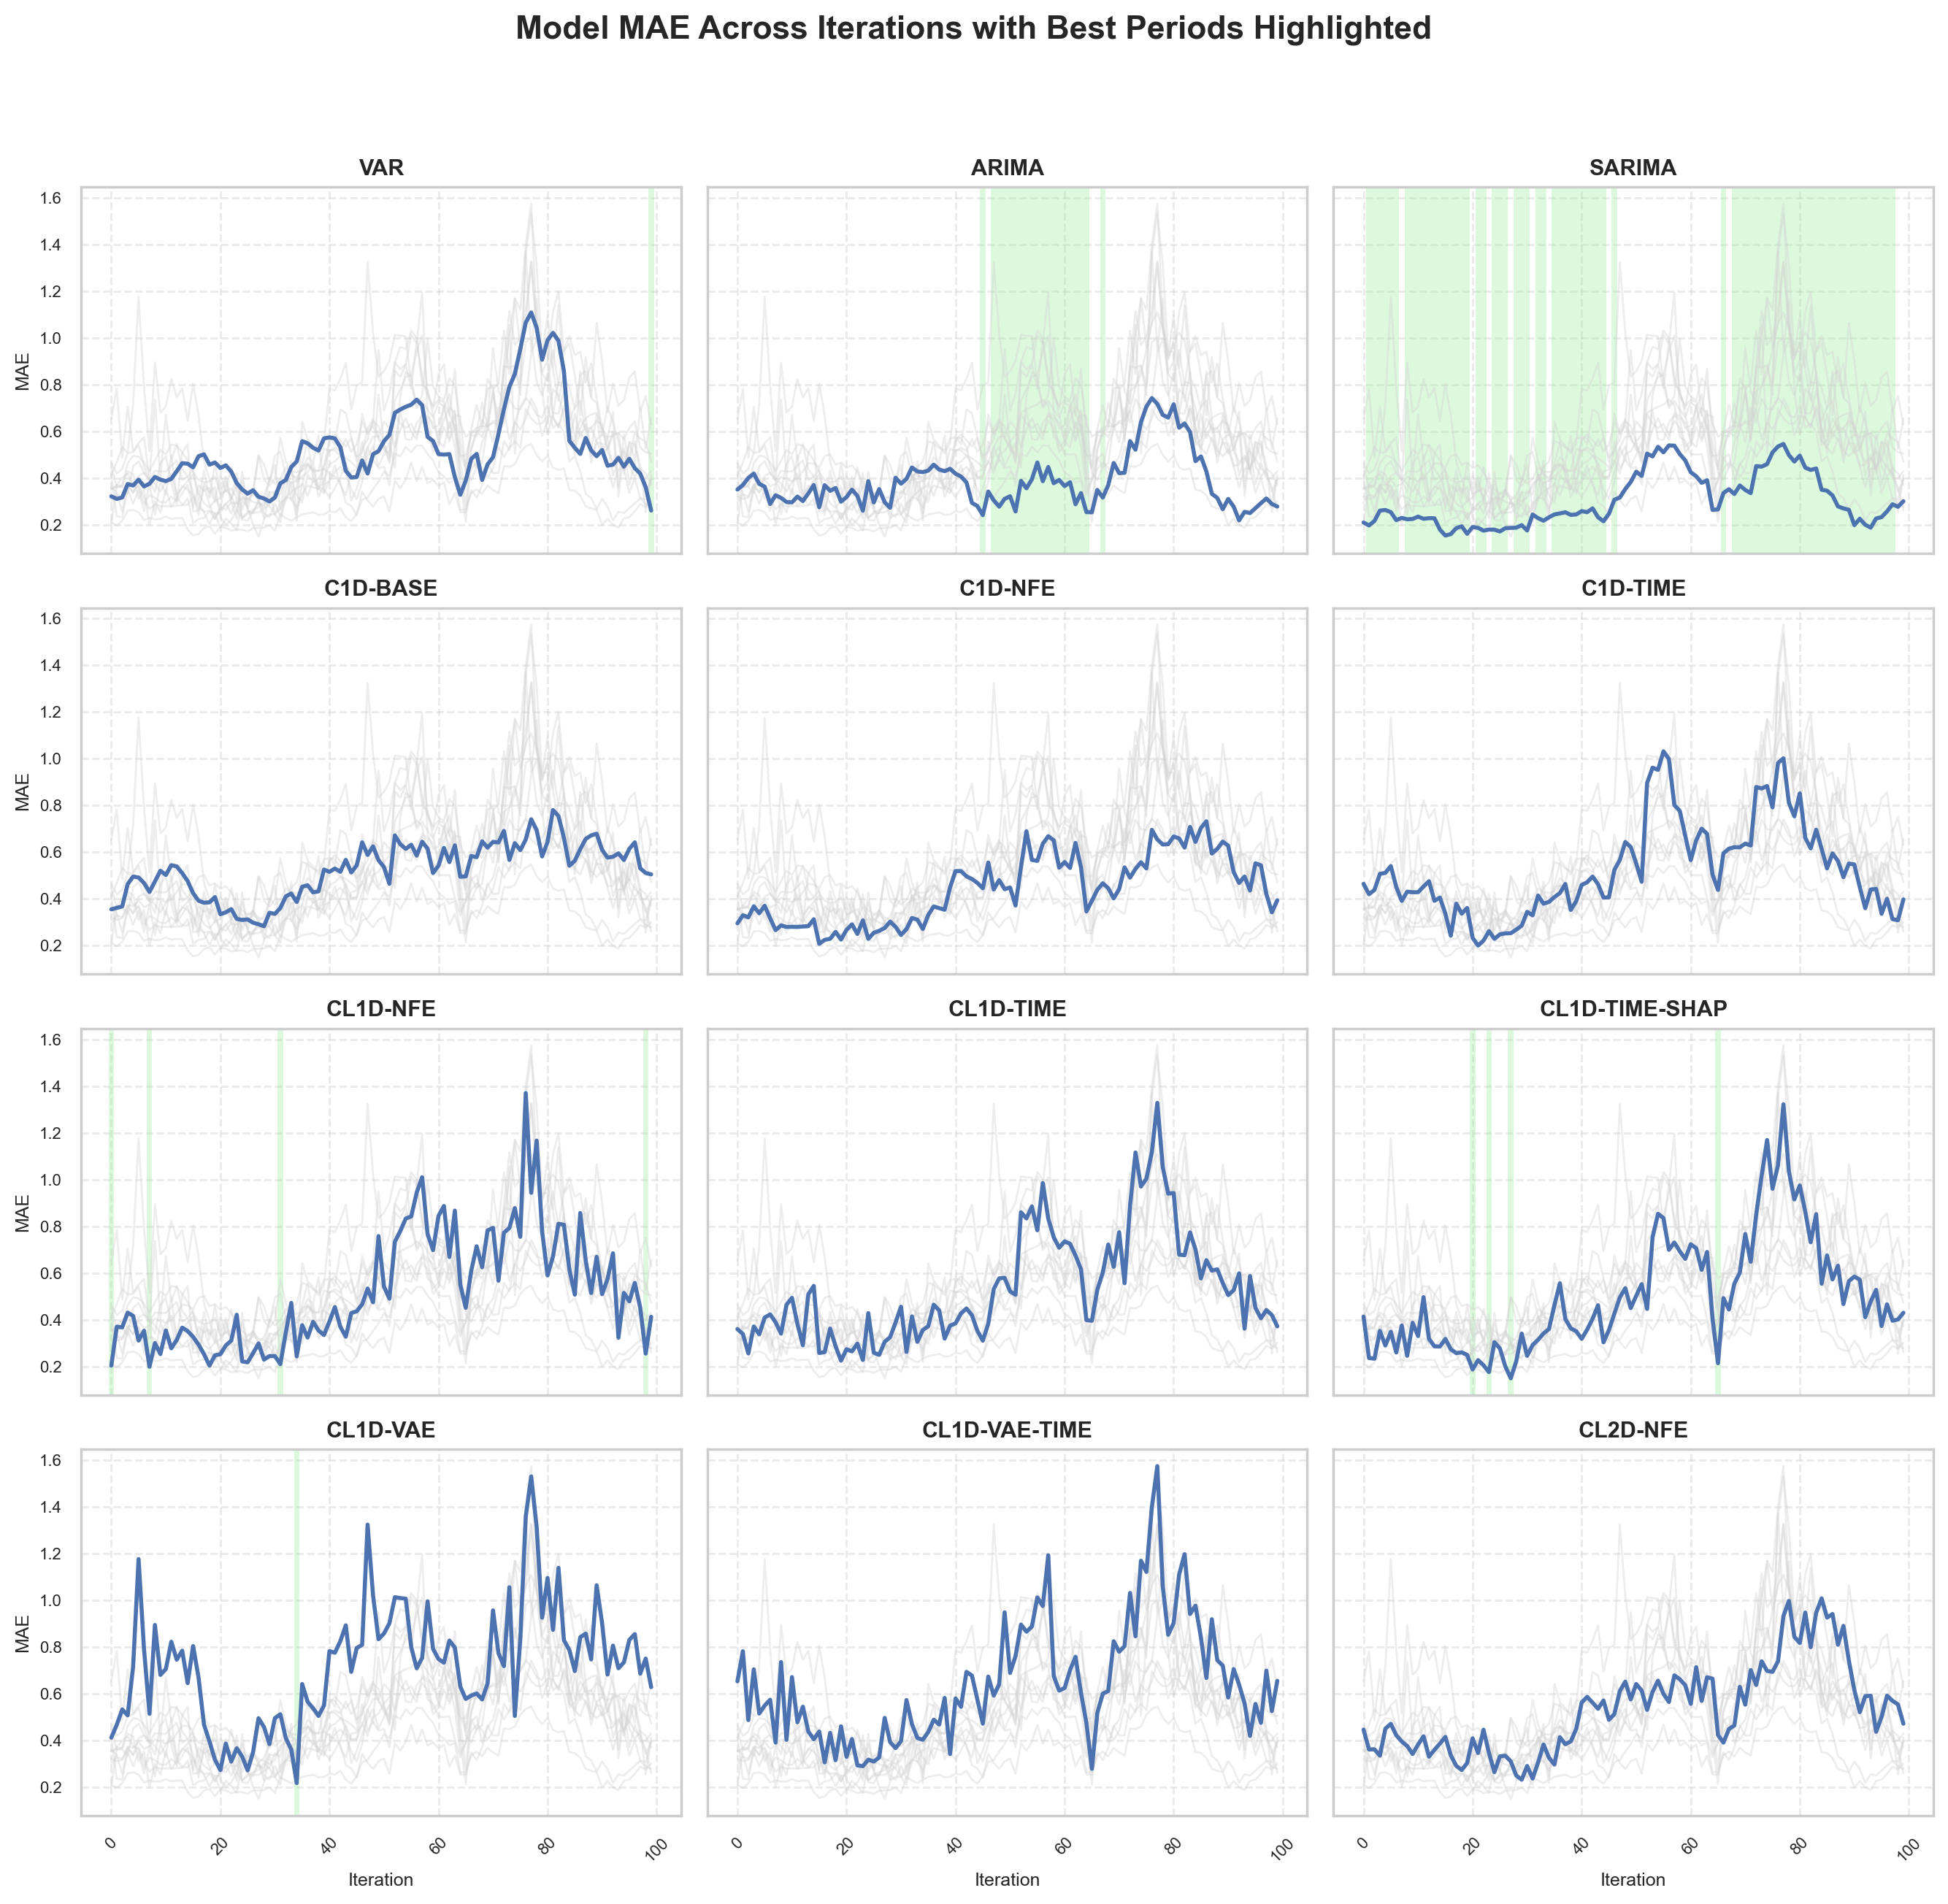

In [67]:
models_to_plot = ['C1D-BASE', 'C1D-NFE', 'C1D-TIME', 'CL1D-TIME']
plot_model_performance_panels_bands(mae_df, title="Model MAE Across Iterations with Best Periods Highlighted")

In [68]:


def plot_mae_with_highlight(mae_df, highlight_models=None, errorbar=('ci',95), title="MAE Across 100 Rolling Samples (With 95% CI)"):
    """
    Plot MAE over iterations with optional highlighting of selected models.

    Parameters:
    - mae_df: DataFrame with shape (iterations, models)
    - highlight_models: List of model names to highlight
    - ci: Confidence interval (default 95)
    - title: Title of the plot
    """
    # Melt the DataFrame to long format
    mae_melted = mae_df.reset_index(drop=True).reset_index().melt(id_vars="index", var_name="Model", value_name="MAE")
    mae_melted = mae_melted.rename(columns={"index": "Iteration"})

    highlight_models = [m.upper() for m in highlight_models] if highlight_models else []

    plt.figure(figsize=(14, 7))

    # Plot all models in gray
    for model in mae_melted['Model'].unique():
        data = mae_melted[mae_melted['Model'] == model]
        if model.upper() not in highlight_models:
            sns.lineplot(data=data, x="Iteration", y="MAE", label=model, color='lightgray', linewidth=1, alpha=0.6, errorbar=None)

    # Plot highlighted models in color
    palette = sns.color_palette("tab10", len(highlight_models))
    for i, model in enumerate(highlight_models):
        data = mae_melted[mae_melted['Model'].str.upper() == model]
        sns.lineplot(data=data, x="Iteration", y="MAE", label=model, linewidth=2.2, errorbar=errorbar, color=palette[i])

    plt.title(title, fontsize=16)
    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("MAE", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="Model", fontsize=10)
    plt.tight_layout()
    plt.show()


In [69]:

def generate_iteration_date_table(start_date_str="1999-04-01", window_size=209, num_iterations=100):
    """
    Generate a DataFrame mapping each iteration to its training sample date span.

    Args:
        start_date_str (str): Start date of the original dataset (e.g., '1999-04-01')
        window_size (int): Number of months in each training window
        num_iterations (int): Total number of iterations/samples

    Returns:
        pd.DataFrame: A table with iteration index, start date, end date, and combined span string
    """
    start_date = pd.to_datetime(start_date_str)

    records = []
    for i in range(num_iterations):
        sample_start = start_date + pd.DateOffset(months=i)
        sample_end = sample_start + pd.DateOffset(months=window_size - 1)
        records.append({
            "Iteration": i,
            "Start Date": sample_start.strftime("%Y-%m-%d"),
            "End Date": sample_end.strftime("%Y-%m-%d"),
            "Sample Span": f"{sample_start.strftime('%Y-%m-%d')} --- {sample_end.strftime('%Y-%m-%d')}"
        })

    return pd.DataFrame(records)


In [70]:
date_table = generate_iteration_date_table()
# print(date_table.to_string(index=False))
date_table.to_csv("iteration_sample_spans.csv", index=False)


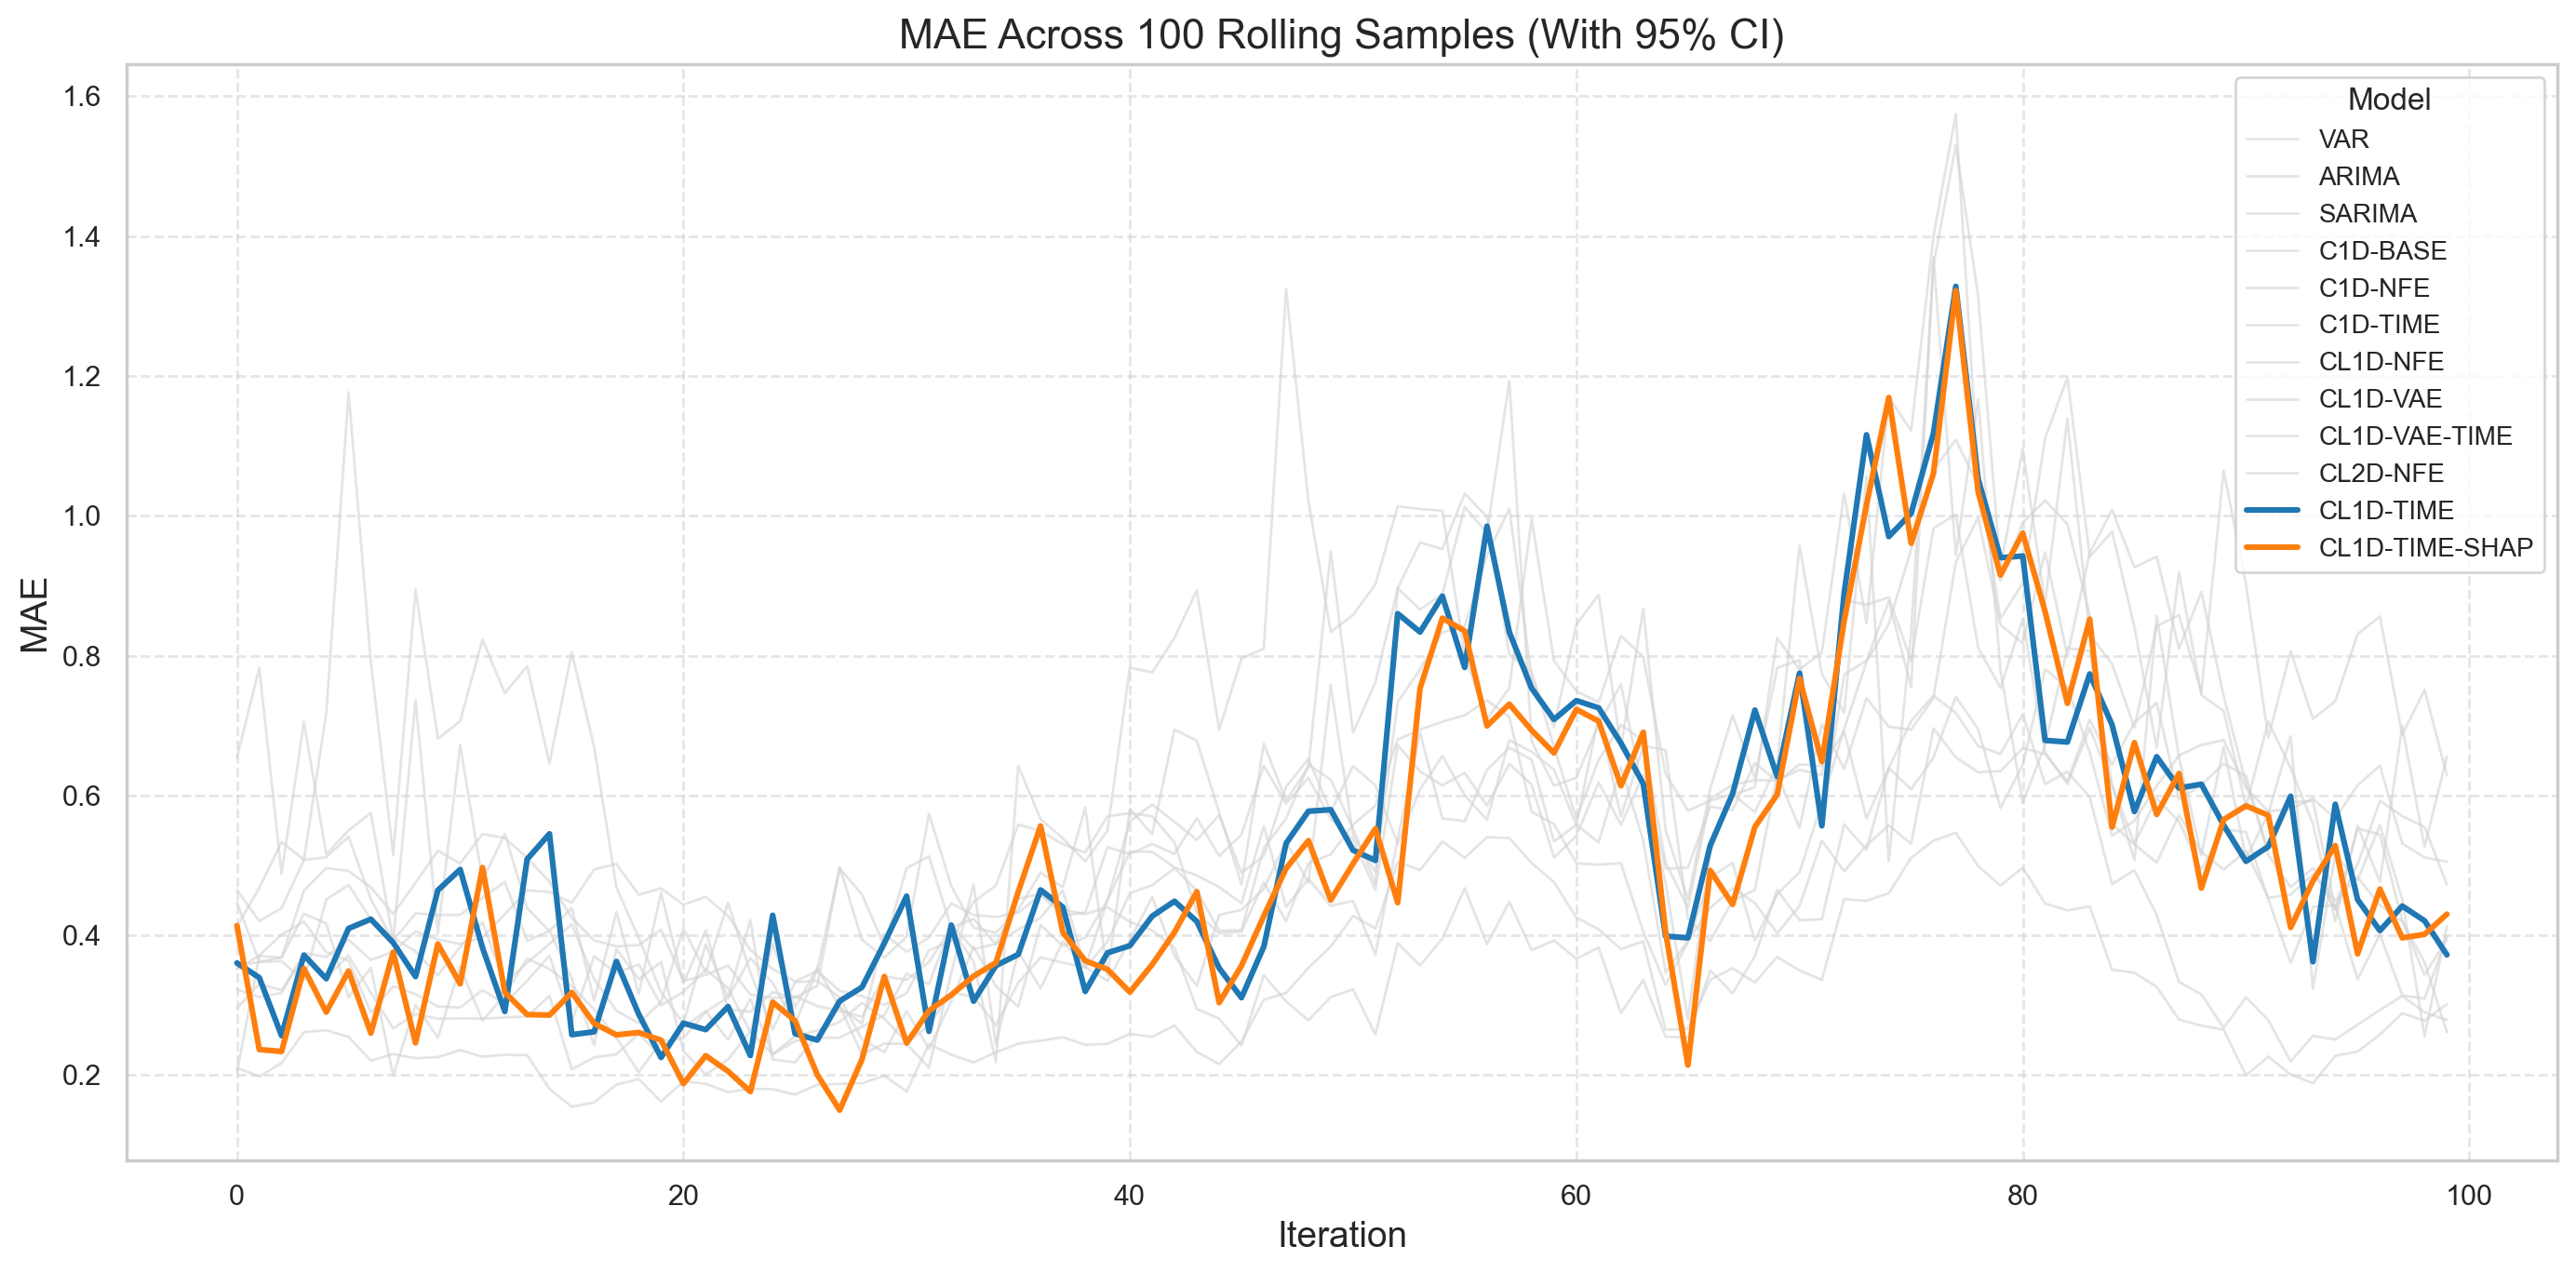

In [71]:
highlight = ['CL1D-TIME', 'CL1D-TIME-SHAP']
plot_mae_with_highlight(mae_df, highlight_models=highlight)

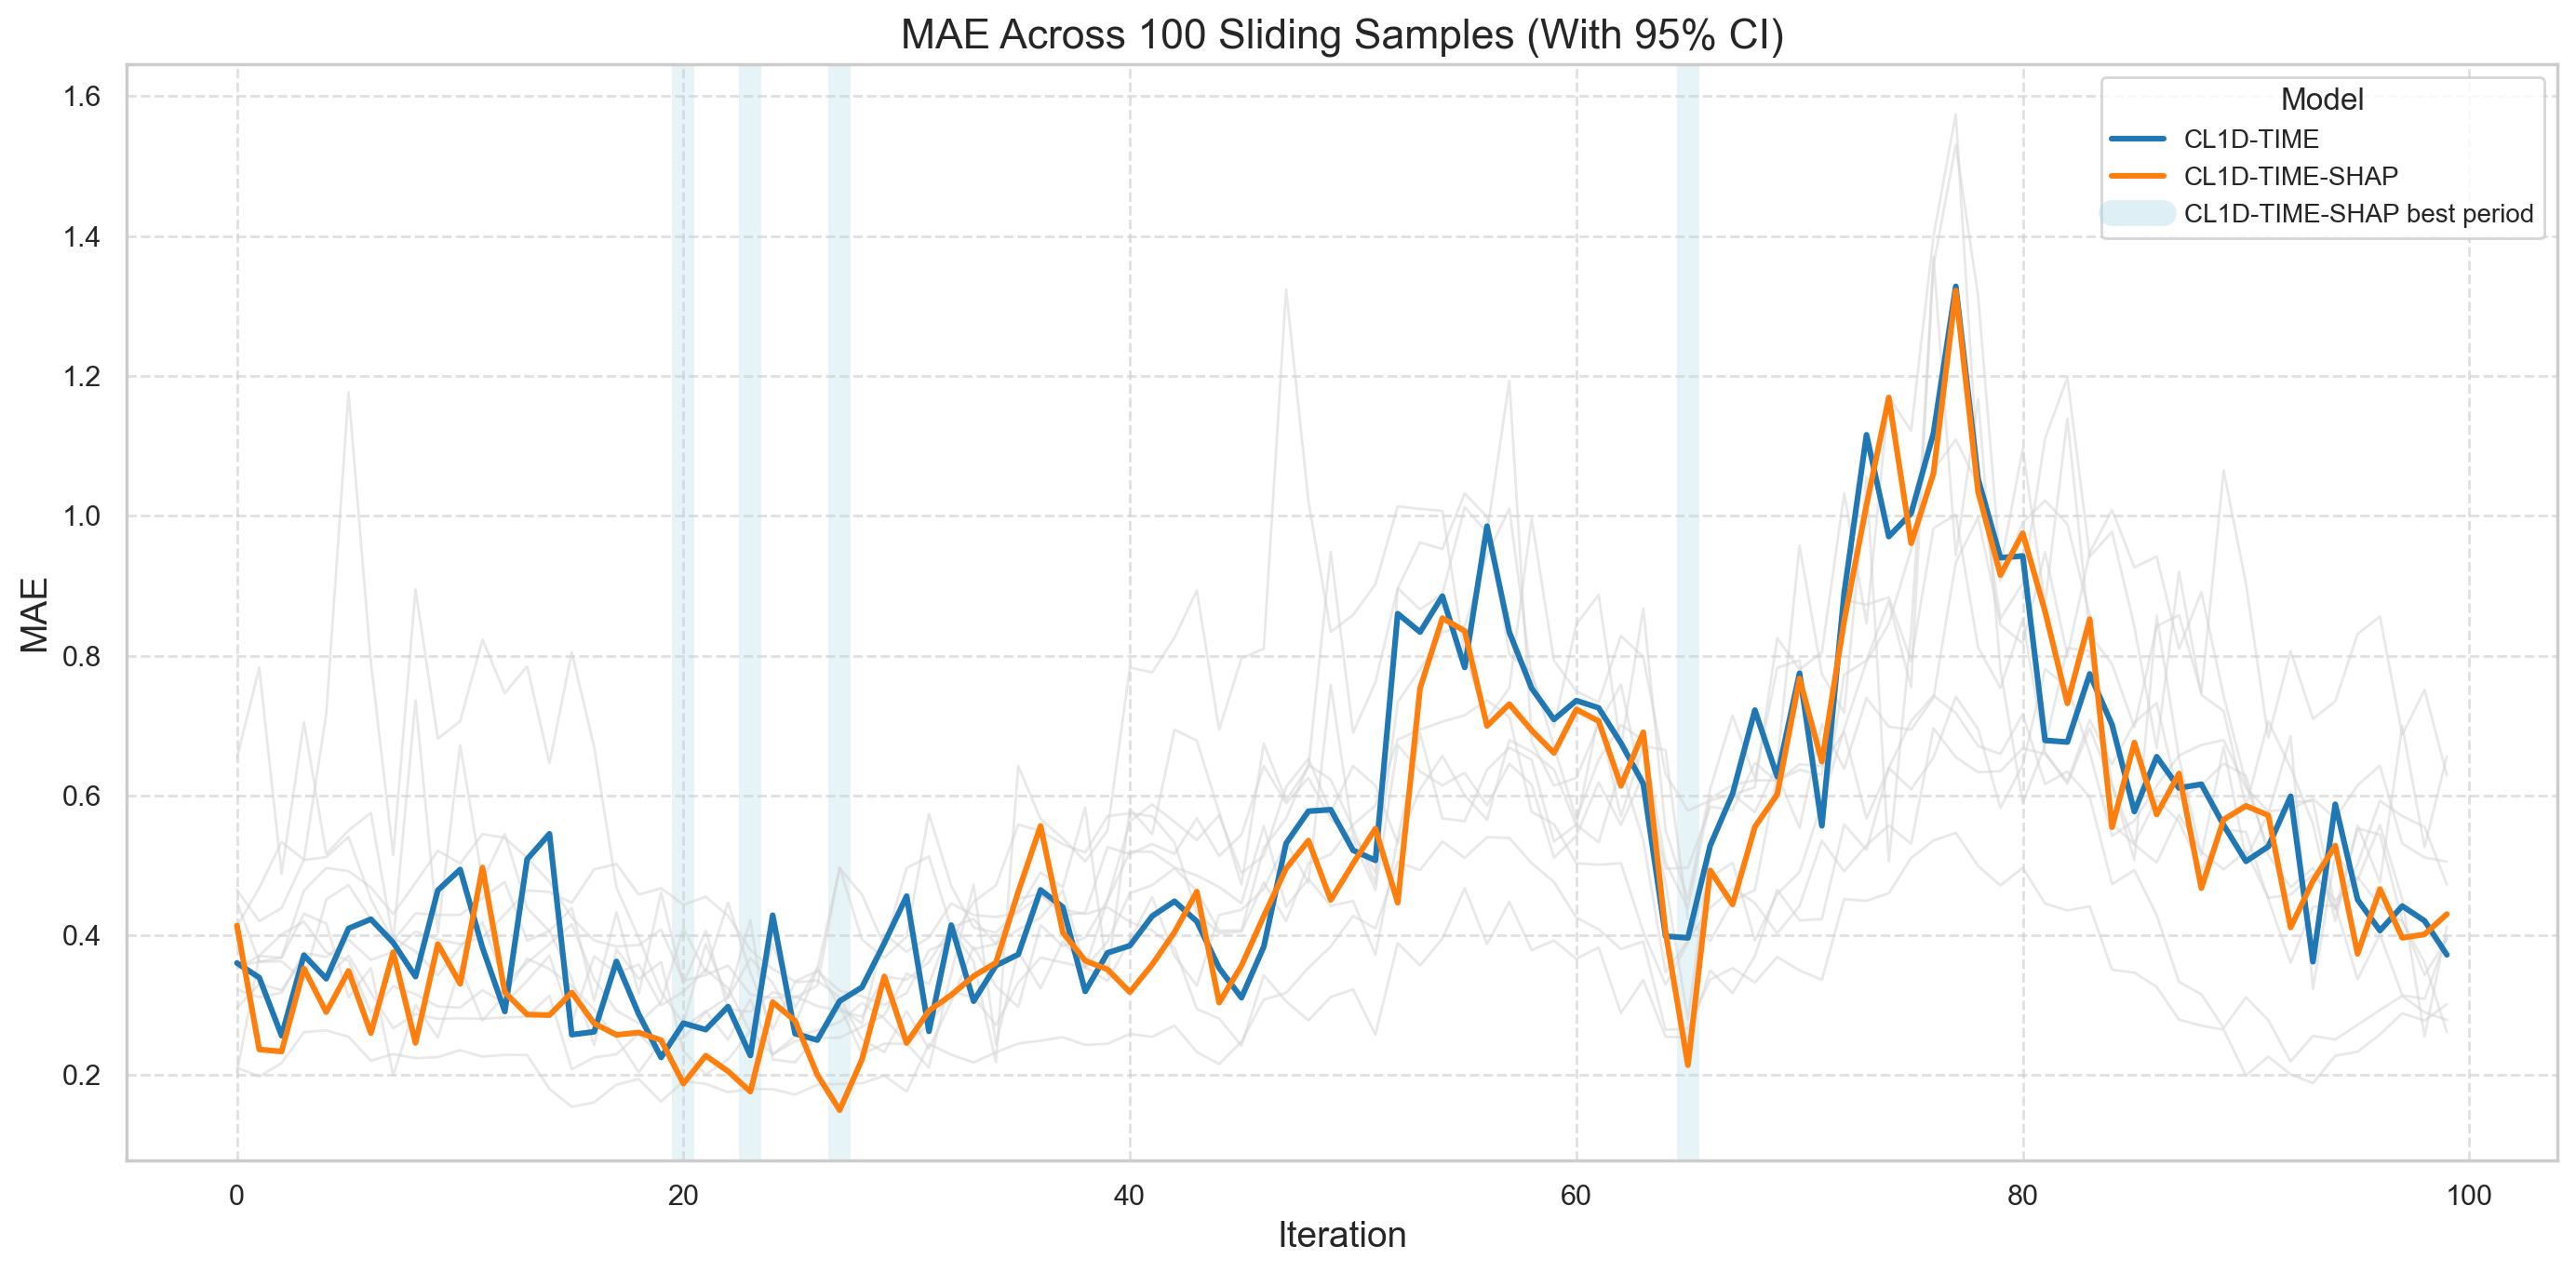

In [72]:
# Highlight two models, and also mark periods where VAR was the best
best_iterations = plot_mae_with_highlight_and_bands(mae_df,
                                                    highlight_models=highlight,
                                                    mark_best_model='CL1D-TIME-SHAP')


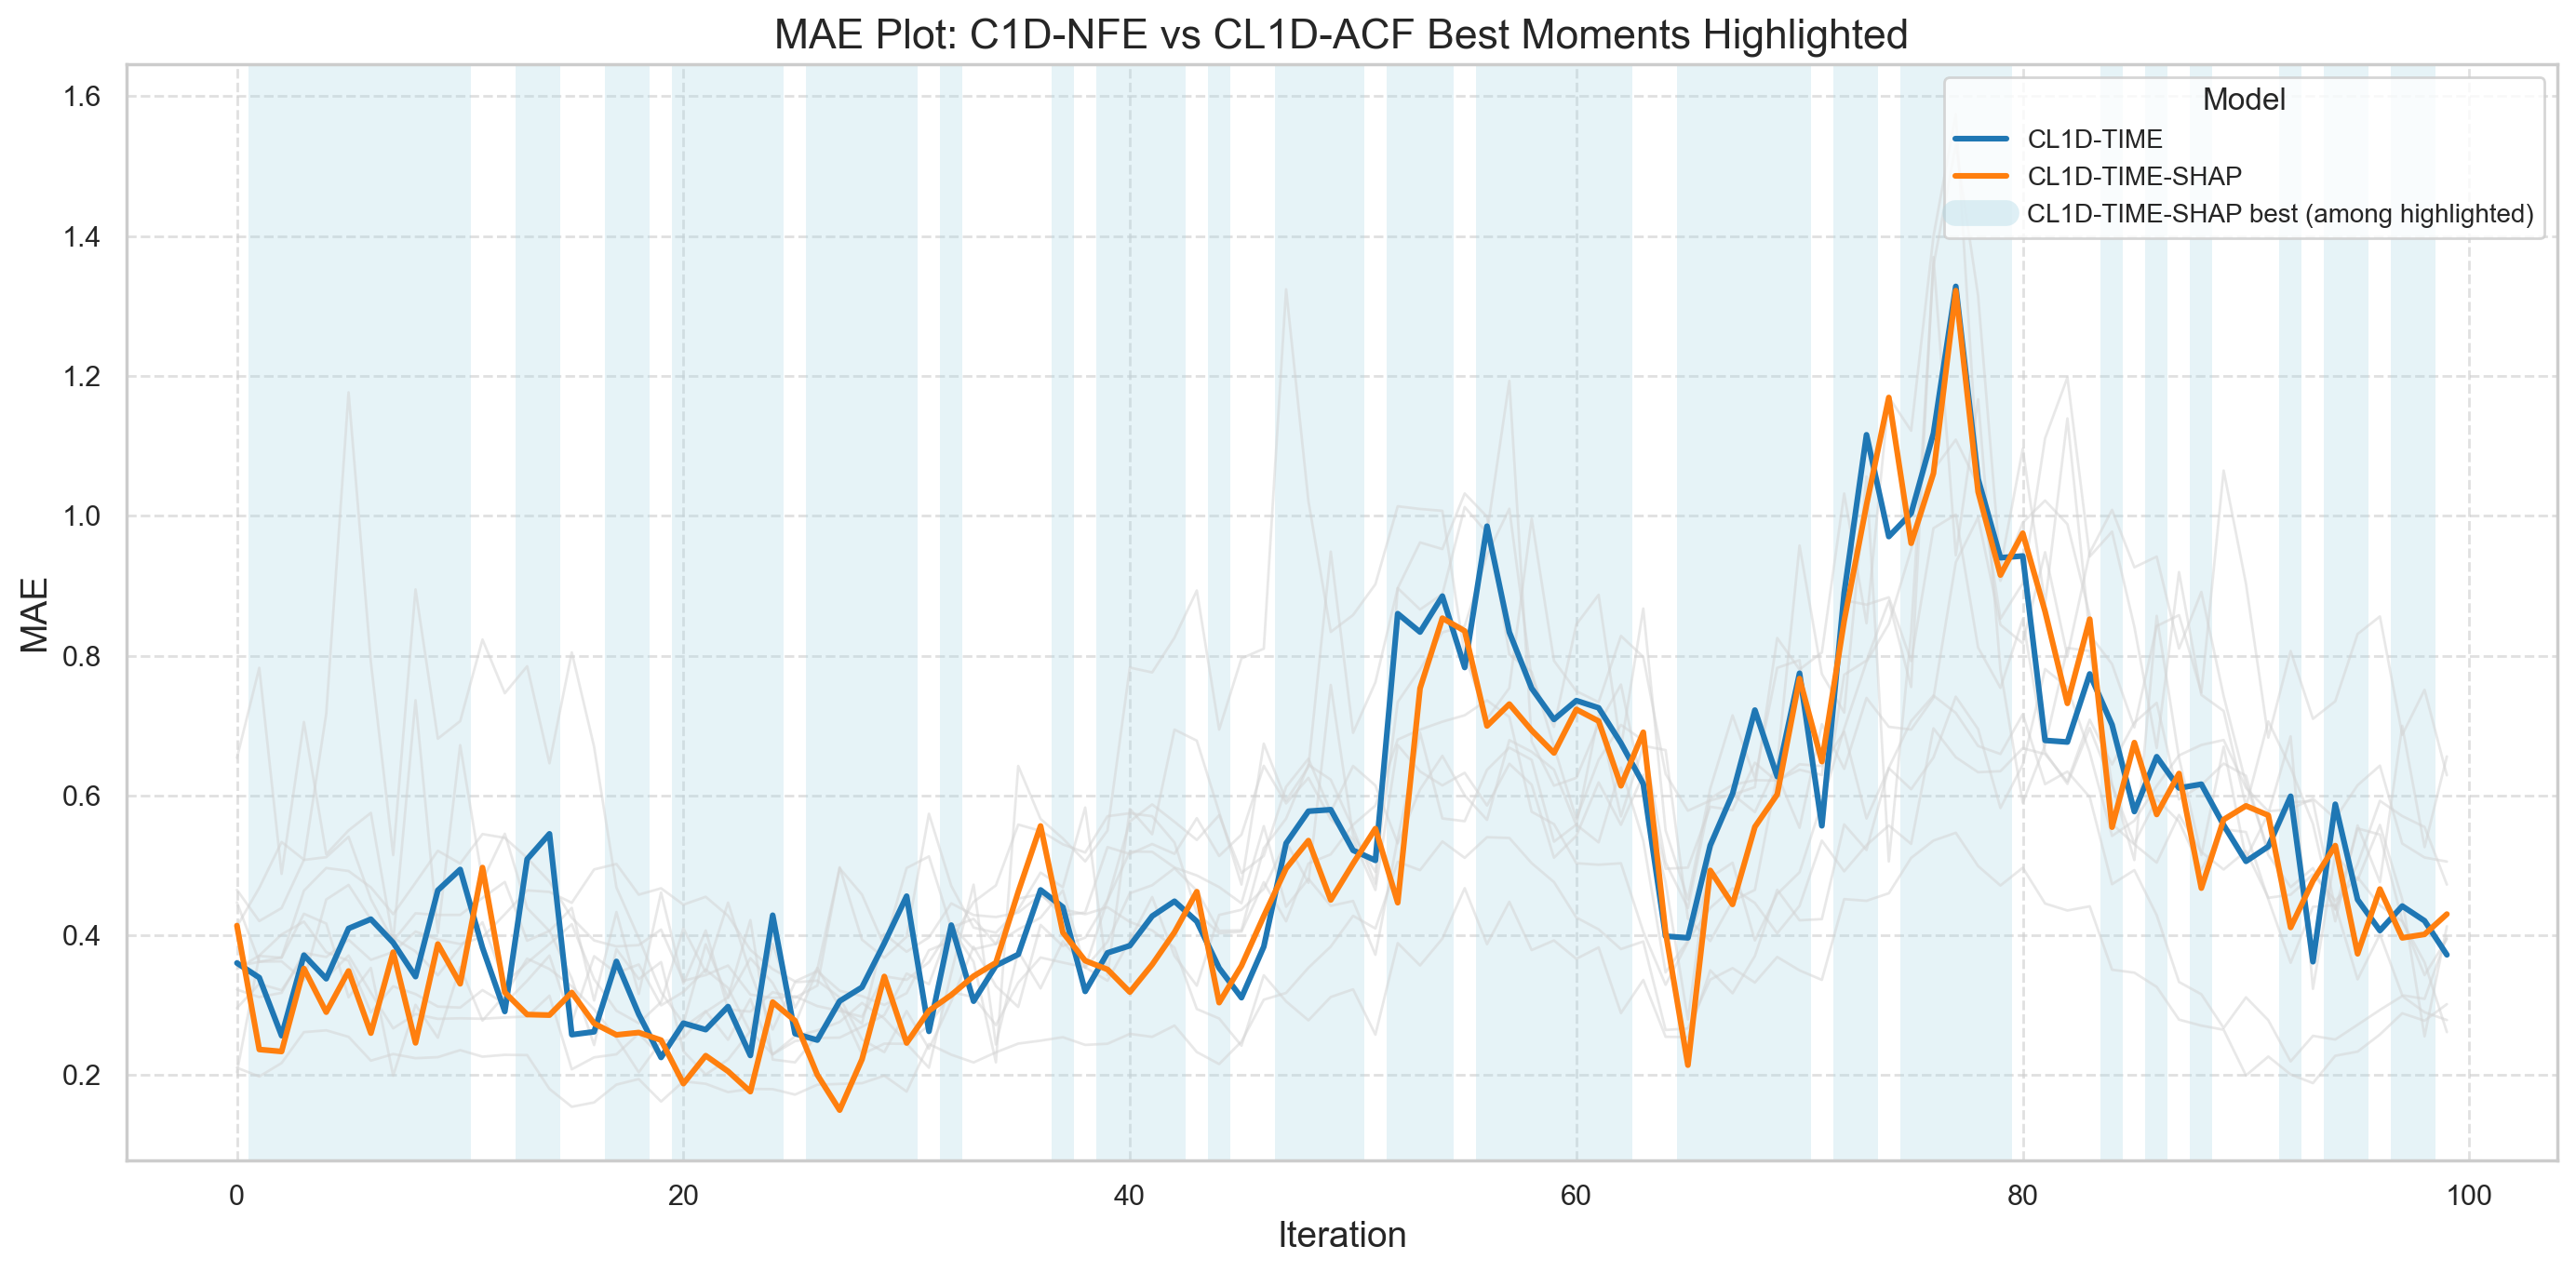

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 13,
 14,
 17,
 18,
 20,
 21,
 22,
 23,
 24,
 26,
 27,
 28,
 29,
 30,
 32,
 37,
 39,
 40,
 41,
 42,
 44,
 47,
 48,
 49,
 50,
 52,
 53,
 54,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 65,
 66,
 67,
 68,
 69,
 70,
 72,
 73,
 75,
 76,
 77,
 78,
 79,
 84,
 86,
 88,
 92,
 94,
 95,
 97,
 98]

In [78]:

plot_mae_with_highlight_bands_btw(
    mae_df,
    highlight_models=highlight, # Highlight all dummy models
    mark_best_model='CL1D-TIME-SHAP',         # Check where CNN is best among all dummy models
    title="MAE Plot: C1D-NFE vs CL1D-ACF Best Moments Highlighted"
)

In [73]:

def generate_test_sample_spans(start_date_str="1999-04-01", train_window=209, test_window=12, num_iterations=100):
    """
    Generate a DataFrame mapping each iteration to its test sample date span.

    Args:
        start_date_str (str): Start date of the full dataset.
        train_window (int): Number of months used for training in each iteration.
        test_window (int): Number of months used for testing in each iteration.
        num_iterations (int): Total number of sliding windows/iterations.

    Returns:
        pd.DataFrame: A table with iteration index, test start date, test end date, and full span string.
    """
    start_date = pd.to_datetime(start_date_str)
    records = []

    for i in range(num_iterations):
        test_start = start_date + pd.DateOffset(months=i + train_window)
        test_end = test_start + pd.DateOffset(months=test_window - 1)
        records.append({
            "Iteration": i,
            "Test Start Date": test_start.strftime("%Y-%m-%d"),
            "Test End Date": test_end.strftime("%Y-%m-%d"),
            "Test Span": f"{test_start.strftime('%Y-%m-%d')} --- {test_end.strftime('%Y-%m-%d')}"
        })

    return pd.DataFrame(records)


MAE Normality Test

In [87]:

def test_mae_normality(mae_df, alpha=0.05):
    """
    Tests whether MAE values per model are normally distributed using Shapiro-Wilk test.

    Parameters:
    - mae_df: DataFrame with each model as a column and iterations as rows
    - alpha: Significance level (default = 0.05)

    Returns:
    - DataFrame with p-values and normality conclusion for each model
    """
    results = []

    for model in mae_df.columns:
        stat, p = shapiro(mae_df[model])
        results.append({
            'Model': model,
            'Shapiro-Wilk p-value': p,
            'Normally Distributed': p > alpha
        })

    return pd.DataFrame(results).sort_values(by='Shapiro-Wilk p-value')


In [88]:
normality_results = test_mae_normality(mae_df)
print(normality_results)

             Model  Shapiro-Wilk p-value  Normally Distributed
0              VAR          6.677452e-09                 False
1            ARIMA          2.991272e-08                 False
2           SARIMA          4.908347e-07                 False
7        CL1D-TIME          6.773742e-06                 False
8   CL1D-TIME-SHAP          1.240949e-05                 False
6         CL1D-NFE          3.619270e-05                 False
10   CL1D-VAE-TIME          1.094589e-04                 False
5         C1D-TIME          1.800079e-04                 False
4          C1D-NFE          3.293945e-04                 False
11        CL2D-NFE          9.685874e-04                 False
3         C1D-BASE          2.718727e-02                 False
9         CL1D-VAE          4.809082e-02                 False


In [90]:
# Prepare results list
wilcoxon_results = []
# Generate all model pairs
model_pairs = list(itertools.combinations(mae_df.columns, 2))

# Perform pairwise Wilcoxon tests
for model_a, model_b in model_pairs:
    try:
        stat, p_value = wilcoxon(mae_df[model_a], mae_df[model_b])
        wilcoxon_results.append({
            'Model A': model_a,
            'Model B': model_b,
            'Wilcoxon Stat': stat,
            'p-value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })
    except Exception as e:
        print(f"Skipped {model_a} vs {model_b}: {e}")
# Convert results to DataFrame
wilcoxon_df = pd.DataFrame(wilcoxon_results).sort_values(by="p-value")
# print(wilcoxon_df)
# wilcoxon_df
# Optional: Save to CSV
# wilcoxon_df.to_csv("wilcoxon_model_comparisons.csv", index=False)


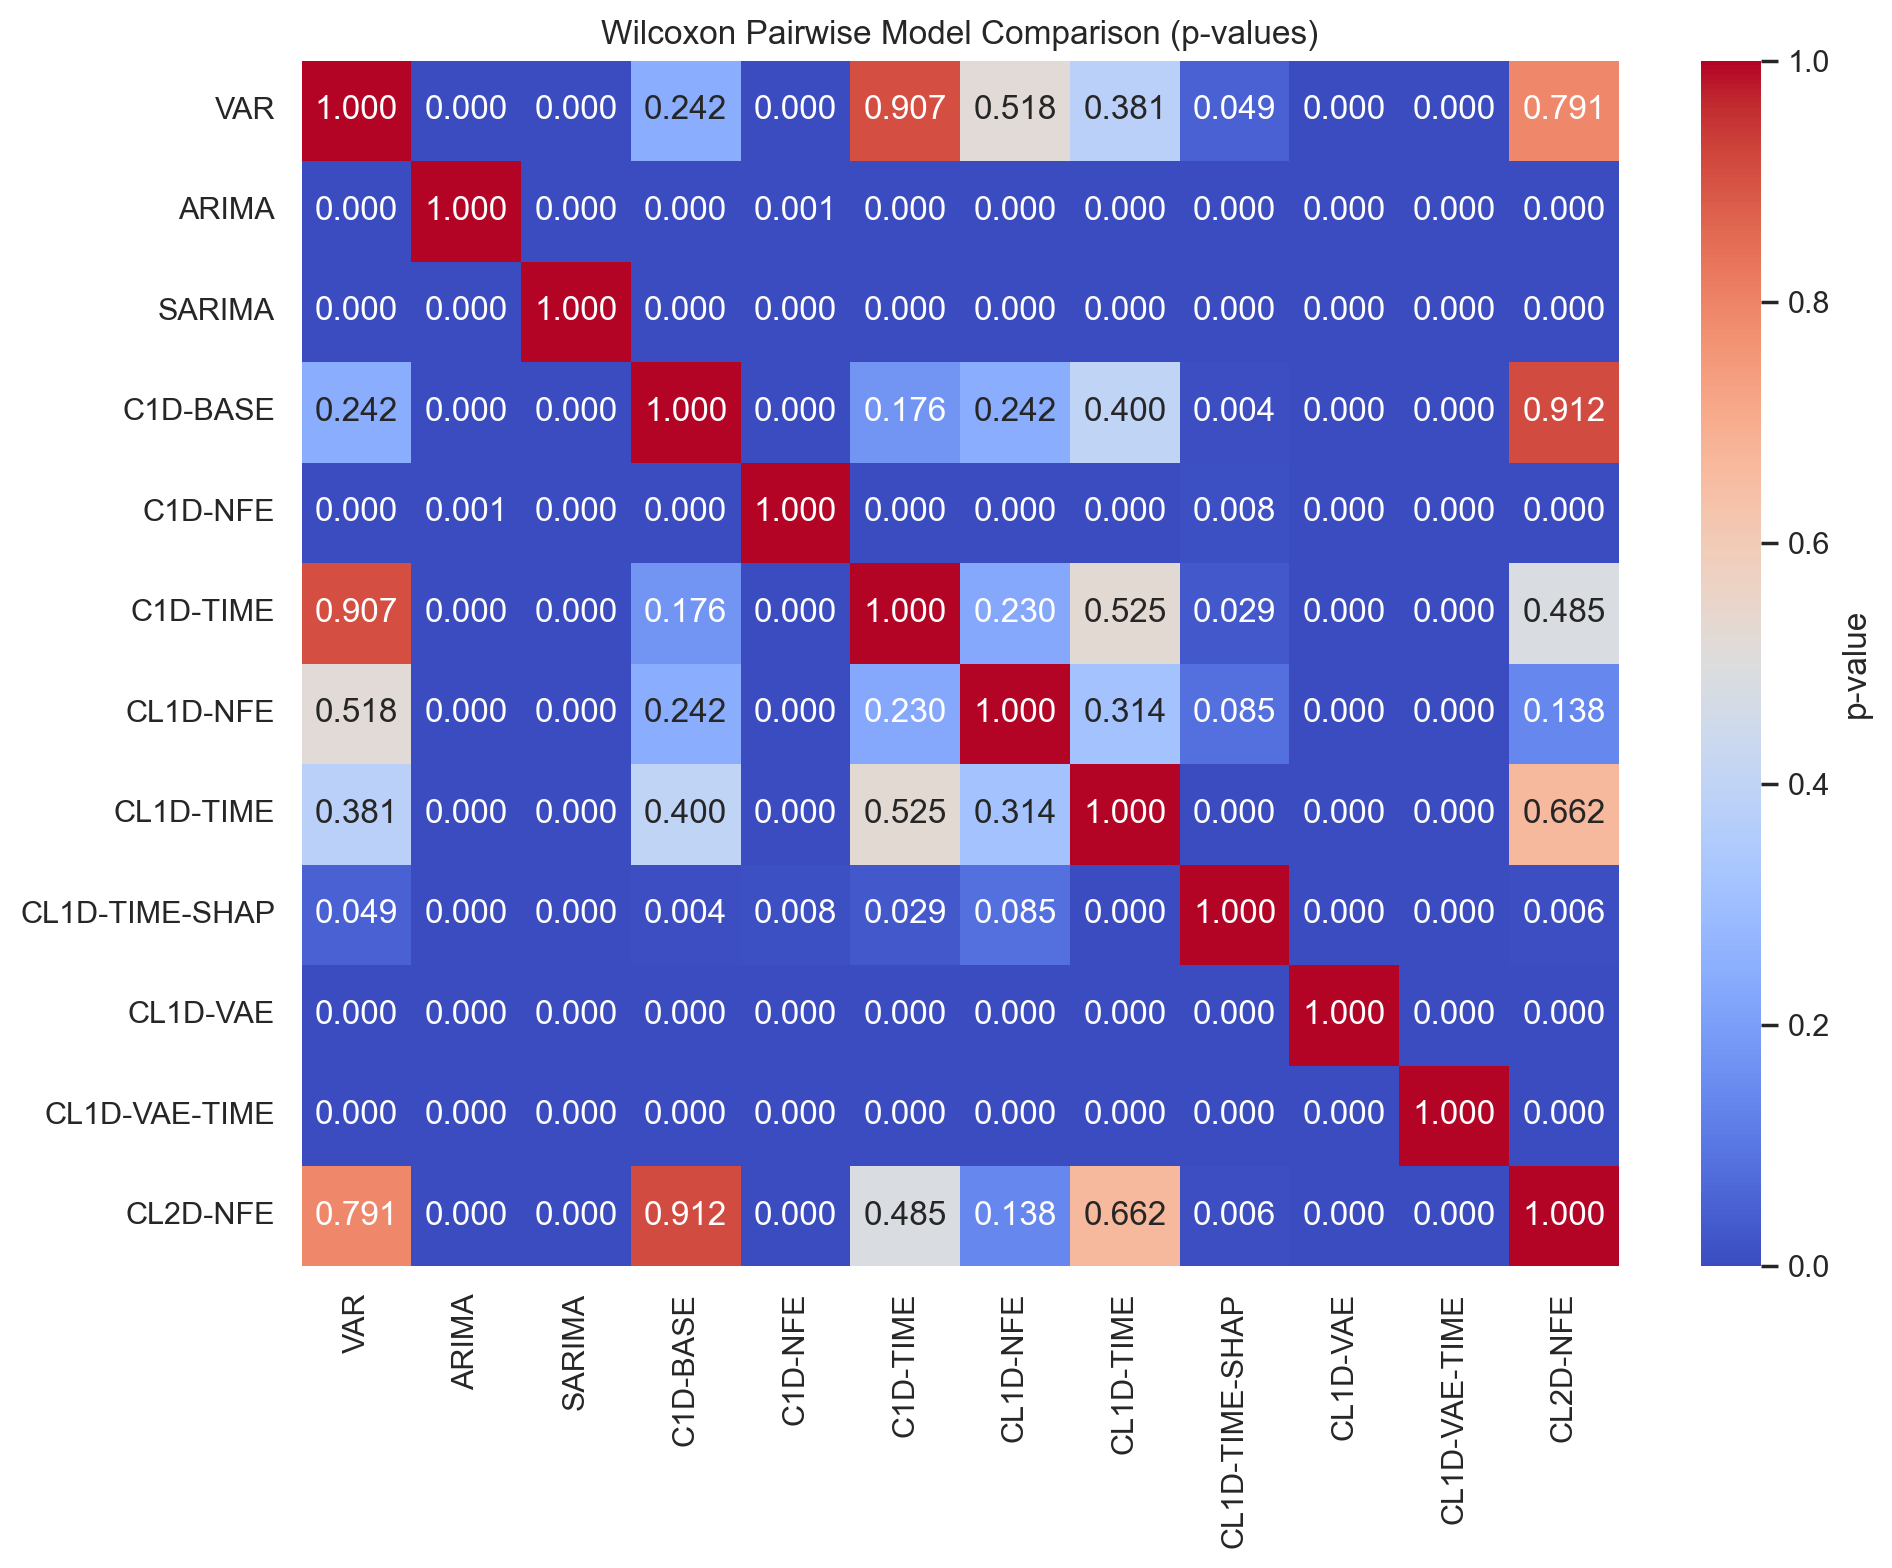

In [91]:
# Create significance matrix
models = mae_df.columns.tolist()
significance_matrix = pd.DataFrame(np.ones((len(models), len(models))), index=models, columns=models)

for _, row in wilcoxon_df.iterrows():
    i, j = row['Model A'], row['Model B']
    significance_matrix.loc[i, j] = row['p-value']
    significance_matrix.loc[j, i] = row['p-value']

# Plot heatmap of p-values
plt.figure(figsize=(10, 8))
sns.heatmap(significance_matrix, annot=True, cmap="coolwarm", fmt=".3f", cbar_kws={"label": "p-value"})
plt.title("Wilcoxon Pairwise Model Comparison (p-values)")
plt.tight_layout()
plt.show()